 **PROJET D’ÉCONOMÉTRIE APPLIQUÉE**

---


Analyse des Prix Immobiliers


In [ ]:
#!pip install linearmodels
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from linearmodels.iv import IV2SLS
import statsmodels.stats.api as sms
from scipy.stats import norm, skew, kurtosis
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, LassoCV
from statsmodels.iolib.summary2 import summary_col
from sklearn.model_selection import train_test_split
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

**Importation du dataset "données_immobilières"**


In [ ]:
from google.colab import files

# Téléchargez le fichier Excel si vous ne l'avez pas déjà fait
files.upload()

# Lecture directe du fichier Excel
df = pd.read_excel('donnees_immobilieres_extended.xlsx')

df.head()

Saving donnees_immobilieres_extended.xlsx to donnees_immobilieres_extended.xlsx


,ID,Surface_m2,Chambres,Annee_construction,Distance_centre_km,Etage,Ascenseur,Annee_vente,Qualite_ecole,Revenu_median_quartier,Distance_universite,Prix_milliers_euros
0,1,139.87,3,1982,21.33,2,1,2023,1.1,47.5,11.9,1961.68
1,2,114.47,4,1991,2.90,5,1,2022,4.7,44.2,11.9,2303.67
2,3,145.91,2,2005,3.00,3,1,2017,3.2,53.8,10.7,2224.12
3,4,180.92,4,1995,29.61,3,1,2022,6.1,68.3,11.1,2425.63
4,5,110.63,3,2016,11.54,0,0,2021,9.0,81.9,10.8,2323.34


In [ ]:
# Vérifier la taille des données
df.shape

(150, 12)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      150 non-null    int64  
 1   Surface_m2              150 non-null    float64
 2   Chambres                150 non-null    int64  
 3   Annee_construction      150 non-null    int64  
 4   Distance_centre_km      150 non-null    float64
 5   Etage                   150 non-null    int64  
 6   Ascenseur               150 non-null    int64  
 7   Annee_vente             150 non-null    int64  
 8   Qualite_ecole           150 non-null    float64
 9   Revenu_median_quartier  150 non-null    float64
 10  Distance_universite     150 non-null    float64
 11  Prix_milliers_euros     150 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 14.2 KB


# **I.  STATISTIQUES DESCRIPTIVES ET ANAYSE PRÉLIMINAIRE**


 **1.1 Statistiques descriptives**

**a) Calcul de la moyenne, médiane, écart-type, minimum, maximum, quartiles pour chaque variable**

In [ ]:
# Sélection des colonnes spécifiques
colonnes_selectionnees = ['Surface_m2',
                          'Chambres',
                          'Annee_construction',
                          'Distance_centre_km',
                          'Etage',
                          'Annee_vente',
                          'Qualite_ecole',
                          'Revenu_median_quartier',
                          'Distance_universite',
                          'Prix_milliers_euros']

# Calcul du tableau récapitulatif
summary = df[colonnes_selectionnees].describe().round(2)

# Sélection et renommage des lignes pertinentes
stats_finales = summary.loc[['mean', '50%', 'std', 'min', 'max', '25%', '75%']]

stats_finales = stats_finales.rename(index={'mean': 'Moyenne',
                                            '50%': 'Médiane',
                                            'std': 'Écart-type',
                                            'min': 'Minimum',
                                            'max': 'Maximum',
                                            '25%': 'Q1 (25%)',
                                            '75%': 'Q3 (75%)'})

stats_finales

,Surface_m2,Chambres,Annee_construction,Distance_centre_km,Etage,Annee_vente,Qualite_ecole,Revenu_median_quartier,Distance_universite,Prix_milliers_euros
Moyenne,116.71,2.89,2001.83,16.50,2.58,2019.84,5.47,63.67,8.06,2107.90
Médiane,117.84,3.00,2002.50,16.87,2.50,2020.00,5.60,63.45,8.30,2105.05
Écart-type,37.69,1.08,11.70,9.02,1.76,2.29,1.87,9.30,3.75,229.92
Minimum,15.21,1.00,1980.00,0.83,0.00,2015.00,1.00,42.90,1.00,1500.77
Maximum,218.53,5.00,2022.00,29.99,5.00,2023.00,10.00,83.90,17.10,2743.04
Q1 (25%),93.24,2.00,1991.00,9.10,1.00,2018.00,4.12,57.50,5.30,1934.28
Q3 (75%),139.64,4.00,2012.00,24.70,4.00,2022.00,7.00,70.47,10.88,2272.78


Statistique de la variable "Ascenseur"

--- Analyse de la variable Ascenseur ---
                    Nombre  Pourcentage (%)
Sans Ascenseur (0)      81             54.0
Avec Ascenseur (1)      69             46.0


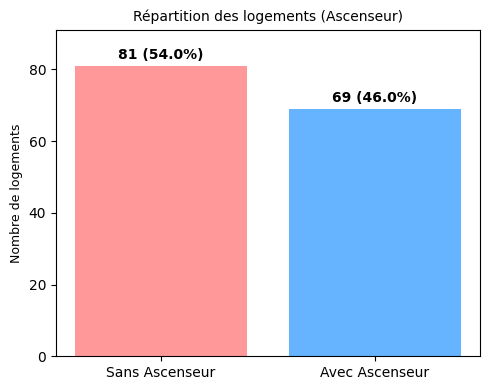

In [ ]:
# Calcul des fréquences
counts = df['Ascenseur'].value_counts().sort_index()
percentages = (df['Ascenseur'].value_counts(normalize=True) * 100).sort_index()

# Création d'un petit tableau récapitulatif
df_ascenseur = pd.DataFrame({'Nombre': counts,'Pourcentage (%)': percentages})
df_ascenseur.index = ['Sans Ascenseur (0)', 'Avec Ascenseur (1)']

print("--- Analyse de la variable Ascenseur ---")
print(df_ascenseur)

## Représentation de la répartition des logements
counts = df['Ascenseur'].value_counts().sort_index()
total = counts.sum()
labels = ['Sans Ascenseur', 'Avec Ascenseur']

# Création du graphique
plt.figure(figsize=(5, 4))
bars = plt.bar(labels, counts.values, color=['#ff9999', '#66b3ff'])
plt.title('Répartition des logements (Ascenseur)', fontsize=10)
plt.ylabel('Nombre de logements', fontsize=9)
plt.ylim(0, counts.max() + 10)

# Ajout des effectifs et des pourcentages au-dessus de chaque barre
for bar in bars:
    yval = bar.get_height()
    percentage = (yval / total) * 100
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1,
             f'{int(yval)} ({percentage:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

**b) Calcul de l'asymétrie (skewness) et l'aplatissement (kurtosis) pour le prix**

In [ ]:
# Skewness et Kurtosis pour le Prix
skew_prix = df['Prix_milliers_euros'].skew()
kurt_prix = df['Prix_milliers_euros'].kurtosis()

print("\n--- Distribution du prix ---")
print(f"Asymétrie (Skewness) : {skew_prix:.2f}")
print(f"Aplatissement (Kurtosis) : {kurt_prix:.2f}")


--- Distribution du prix ---
Asymétrie (Skewness) : 0.16
Aplatissement (Kurtosis) : -0.47


Représentation graphique et interprétation

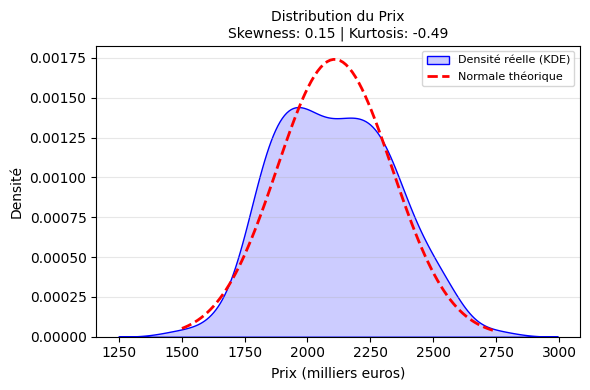

In [ ]:
# Calcul des indicateurs
prix = df['Prix_milliers_euros']
sk = skew(prix)
kt = kurtosis(prix)

# Création de la figure (taille réduite)
plt.figure(figsize=(6, 4))

# Courbe de densité uniquement (KDE)
sns.kdeplot(prix, color='blue', fill=True, alpha=0.2, label='Densité réelle (KDE)')

# Courbe normale théorique pour comparaison (pointillée)
mu, std = norm.fit(prix)
x = np.linspace(prix.min(), prix.max(), 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r--', linewidth=2, label='Normale théorique')

# Personnalisation
plt.title(f'Distribution du Prix\nSkewness: {sk:.2f} | Kurtosis: {kt:.2f}', fontsize=10)
plt.xlabel('Prix (milliers euros)')
plt.ylabel('Densité')
plt.legend(fontsize=8)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Le **Skewness** (coefficient d'asymétrie) mesure si les données sont réparties de manière symétrique autour de la moyenne ou si elles *penchent* d'un côté.

Notre coefficient ici est de **0,16**, qui nous indique que la distribution est presque symétrique. Puisque la valeur est légèrement positive, il y a une infime tendance à avoir quelques propriétés plus chères que la moyenne, mais rien de très marqué.

Le **Kurtosis** (coefficient d'aplatissement) mesure *l'épaisseur* des queues de la distribution et donc la présence de valeurs extrêmes (outliers) par rapport à une loi normale.

Nous avons un coefficient de **-0,47**. Notre distribution est un peu plus "plate" qu'une courbe normale. Cela signifie que les prix sont bien répartis sur une plage large et qu'il y a peu de valeurs extrêmes (très peu de maisons hors de prix).

En résumé, le prix est réparti de façon assez uniforme autour de la moyenne, ce qui rend les analyses statistiques plus fiables.

**c) Visualisation des distibutions**

Dans notre échantillon, nous retrouvons les types de données suivants :

**Variables Quantitatives Continues**

Ce sont des mesures qui peuvent prendre une infinité de valeurs (avec décimales). Ce sont les candidates pour les histogrammes et les transformations logarithmiques.

- Prix_milliers_euros (float64) : La variable cible (dépendante).
- Surface_m2 (float64) : Variable explicative majeure.
- Revenu_median_quartier (float64) : Indicateur socio-économique.
- Distance_centre_km (float64) : Mesure géographique.
- Distance_universite (float64) : Mesure géographique.
- Qualite_ecole (float64) : Note sur 10 (ex: 7.5). Même si c'est une note, elle est traitée comme continue ici.

**Variables Quantitatives Discrètes**

Ce sont des nombres entiers issus d'un comptage. On ne peut pas avoir 2.5 chambres.

- Chambres (int64) : Nombre de pièces (1, 2, 3...).
- Etage (int64) : Niveau de l'appartement (0, 1, 2...).

**Variables Qualitatives Binaires**

Variables qui ne prennent que deux valeurs (0 ou 1) pour indiquer une présence ou une absence.

- Ascenseur (int64) : 1 si oui, 0 si non.

**Variables Temporelles**

Dates ou années.

- Annee_construction (int64)
- Annee_vente (int64)

**Identifiant**

- ID (int64) : N'a aucune signification statistique.


**L'analyse des distributions et la recherche de transformation logarithmique se limitent aux variables quantitatives continues. Les variables discrètes ou binaires ont été exclues car la transformation logarithmique  est mathématiquement inadaptée ou statistiquement inutile.**


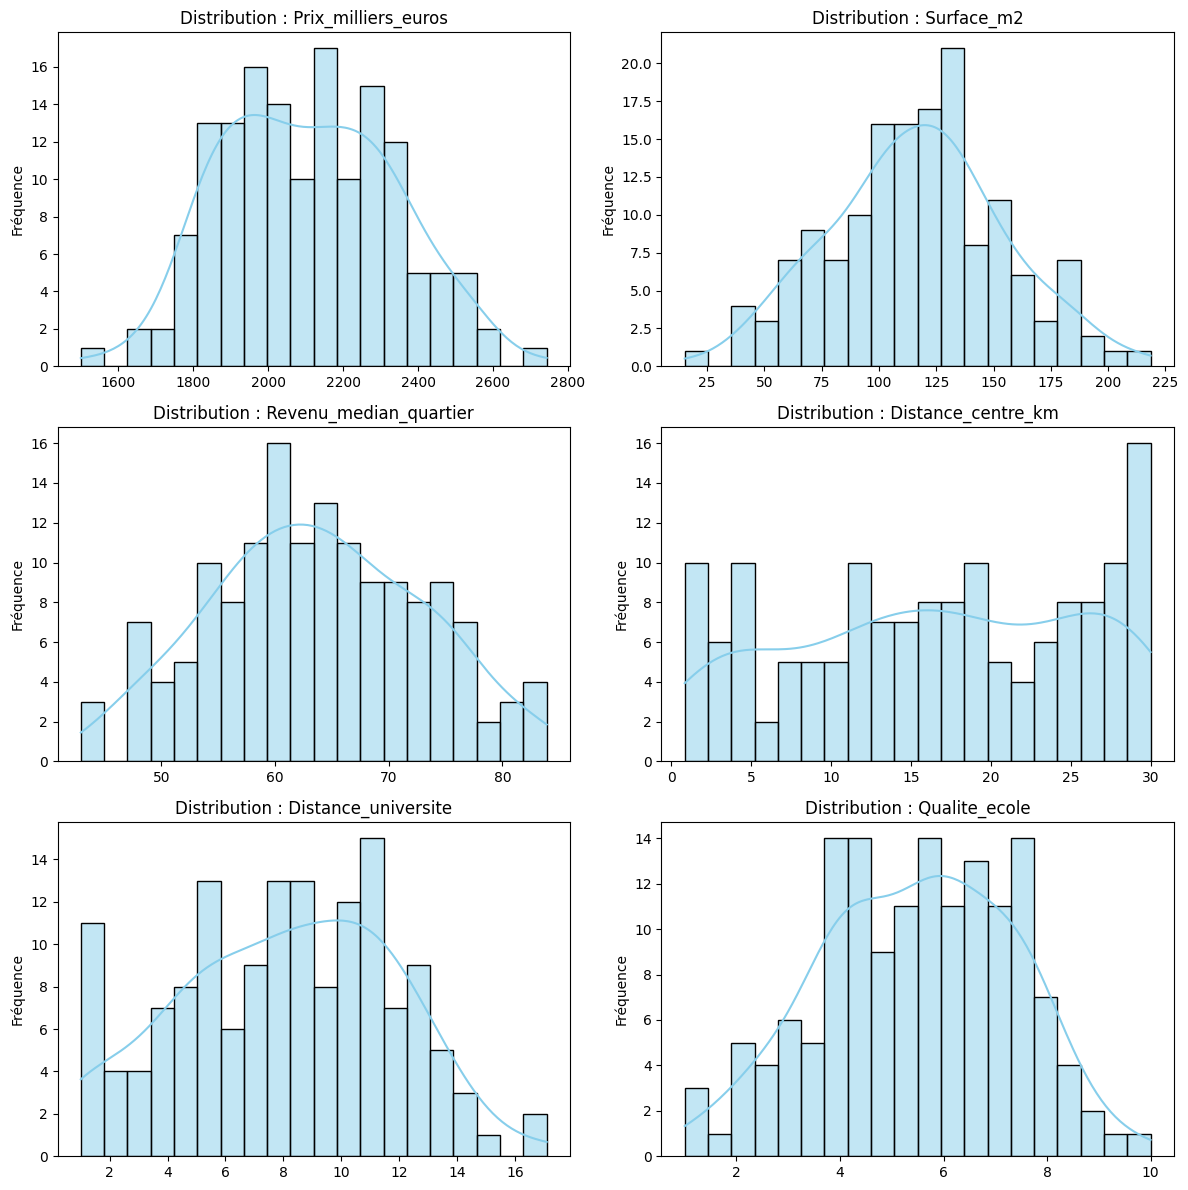

In [ ]:
# Liste des variables continues
variables_a_tracer = ['Prix_milliers_euros',
                      'Surface_m2',
                      'Revenu_median_quartier',
                      'Distance_centre_km',
                      'Distance_universite',
                      'Qualite_ecole']

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Boucle de traçage
for i, col in enumerate(variables_a_tracer):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue', bins=20)
    axes[i].set_title(f'Distribution : {col}', fontsize=12)
    axes[i].set_ylabel('Fréquence')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

*L'absence d'asymétrie marquée dans les distributions nous a dispensés de recourir à la transformation logarithmique.*

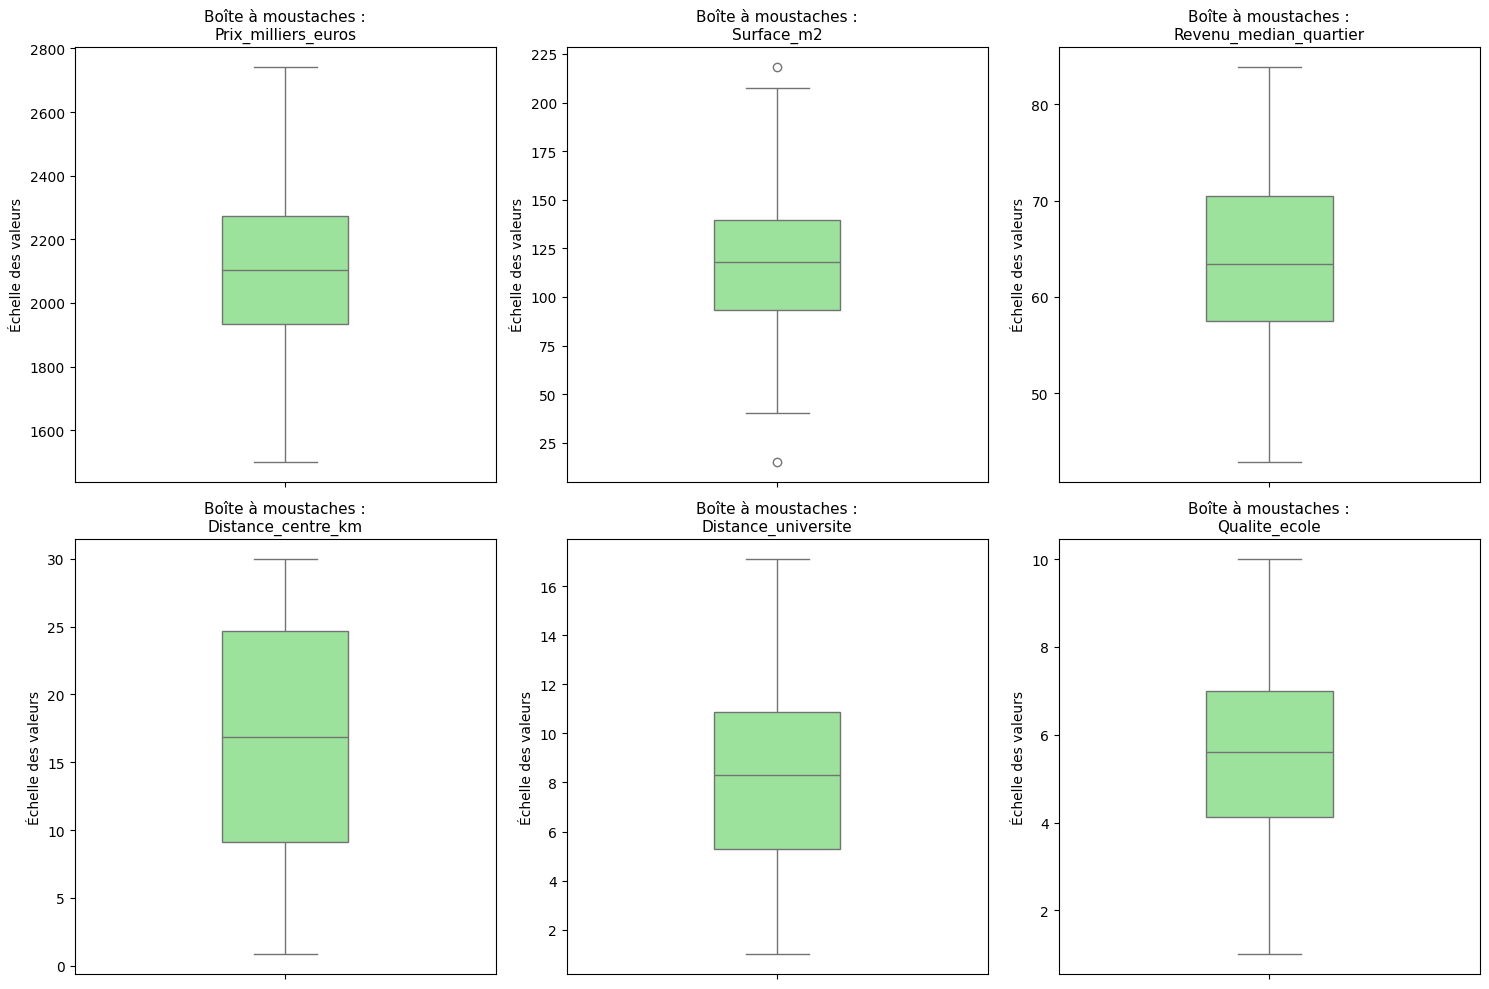

In [ ]:
# Liste des variables
variables_a_tracer = ['Prix_milliers_euros',
                      'Surface_m2',
                      'Revenu_median_quartier',
                      'Distance_centre_km',
                      'Distance_universite',
                      'Qualite_ecole']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Boucle de traçage
for i, col in enumerate(variables_a_tracer):
    sns.boxplot(y=df[col], ax=axes[i], color='lightgreen', width=0.3)
    axes[i].set_title(f'Boîte à moustaches :\n{col}', fontsize=11)
    axes[i].set_ylabel('Échelle des valeurs')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

 **1.2 Analyse de corrélation**

**a) Calcul de la matrice de corrélation**

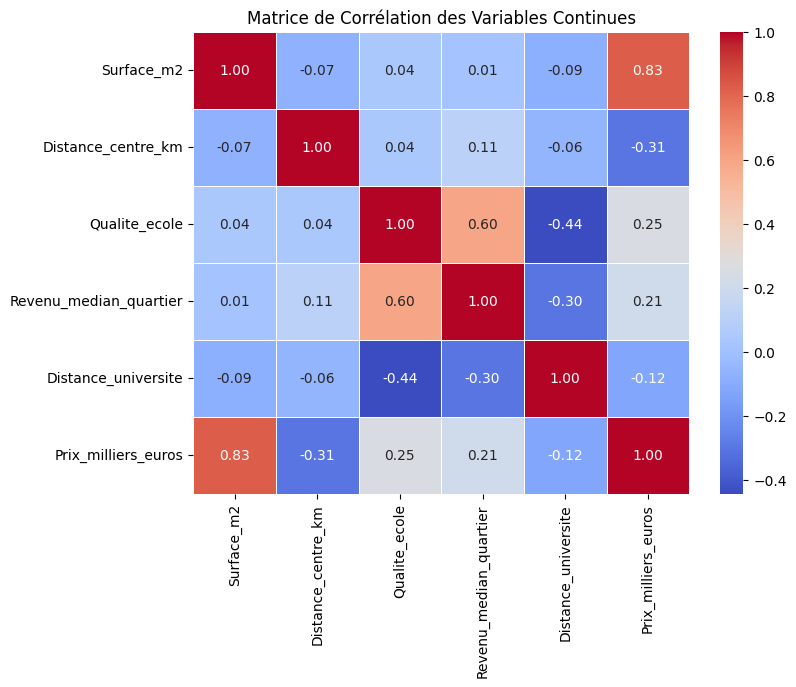

In [ ]:
# Liste des variables strictement continues
vars_continues = ['Surface_m2',
                  'Distance_centre_km',
                  'Qualite_ecole',
                  'Revenu_median_quartier',
                  'Distance_universite',
                  'Prix_milliers_euros']

# Calcul de la matrice de corrélation (Pearson par défaut)
matrice_corr = df[vars_continues].corr()

# Visualisation avec une Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matrice_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matrice de Corrélation des Variables Continues')
plt.show()

**b) Analyse de corrélation entre les variables**

---

L'analyse de la corrélation entre les variables permet de détecter les risques de multicolinéarité. La multicolinéarité survient quand deux variables indépendantes sont trop fortement liées, ce qui peut rendre instable un modèle de régression.

**Relation Surface / Prix (0.83)** : Il existe une corrélation positive très forte. C'est le facteur le plus influent sur le prix.

**Qualité École / Revenu Médian (0.60)** : On observe une corrélation positive marquée. Elle indique que les quartiers avec des revenus plus élevés ont tendance à avoir des écoles de meilleure qualité.

**Qualité École / Distance Université (-0.44)** : Une corrélation négative qui suggère que les écoles de meilleure qualité pourraient être situées plus près des pôles universitaires.

**Relation Distance Centre / Prix (-0.31)** : Corrélation négative modérée. Plus on s'éloigne du centre, plus le prix a tendance à baisser.

# **II.  LE MODÈLE LINÉAIRE : ESTIMATION ET INTERPRÉTATION**

**2.1 Modèle de régression linéaire simple**

In [ ]:
# Définition des variables
# y est la variable à prédire (Prix)
# X est la variable explicative (Surface)
y = df['Prix_milliers_euros']
X = df['Surface_m2']

# Ajout d'une constante (indispensable pour calculer l'intercept beta0)
X = sm.add_constant(X)

# Création et ajustement du modèle MCO
modele = sm.OLS(y, X).fit()

# Affichage du résumé complet des résultats
print(modele.summary())

                             OLS Regression Results                            
Dep. Variable:     Prix_milliers_euros   R-squared:                       0.683
Model:                             OLS   Adj. R-squared:                  0.681
Method:                  Least Squares   F-statistic:                     319.6
Date:                 Wed, 31 Dec 2025   Prob (F-statistic):           8.45e-39
Time:                         13:18:47   Log-Likelihood:                -941.72
No. Observations:                  150   AIC:                             1887.
Df Residuals:                      148   BIC:                             1893.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1519.3743     34.584     43.93

L'estimateur $\hat{\beta}_0 = 1519.37$ représente le prix théorique d'un bien dont la surface serait de $0\text{ m}^2$.

L'estimateur $\hat{\beta}_1 = 5.04$ indique qu'en moyenne, chaque mètre carré supplémentaire augmente le prix de l'immobilier de $5.04$ milliers d'euros (soit environ $5\,040$ €), toutes choses égales par ailleurs.

La $p$-valeur associée à la surface est égale à $0$, ce qui signifie que la surface a un effet statistiquement très significatif sur le prix.

$R^2$ : environ $68.3$ % de la variation des prix est expliquée par la seule variation de la surface. C'est un score élevé pour une régression avec une seule variable, confirmant que la surface est le moteur principal du prix.


---


Si la surface augmente de $1 \text{ m}^2$, le prix augmente en moyenne de $5,04$ milliers d'euros, soit $5\,040$ €.

**2.2 Modèle de régression linéaire multiple**

In [ ]:
# On sélectionne les variables explicatives (X) et la cible (y)
X1 = df[['Surface_m2', 'Chambres', 'Annee_construction', 'Distance_centre_km', 'Etage', 'Ascenseur']]
y1 = df['Prix_milliers_euros']

# Ajout de la constante (pour beta0)
X1 = sm.add_constant(X1)

# Ajustement du modèle MCO
modele_multiple = sm.OLS(y1, X1).fit()

print(modele_multiple.summary())

                             OLS Regression Results                            
Dep. Variable:     Prix_milliers_euros   R-squared:                       0.789
Model:                             OLS   Adj. R-squared:                  0.780
Method:                  Least Squares   F-statistic:                     88.94
Date:                 Wed, 31 Dec 2025   Prob (F-statistic):           9.10e-46
Time:                         13:18:47   Log-Likelihood:                -911.43
No. Observations:                  150   AIC:                             1837.
Df Residuals:                      143   BIC:                             1858.
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1679.4

1. Significativité : Toutes les variables sélectionnées sont
significatives au seuil de $5\%$ (leurs $p$-valeurs sont inférieures à $0.05$).

La p-valeur de la constante est de 0,2759 (soit > 0,05). Cela signifie que la constante n'est pas significative. Dans ce contexte, cela veut dire que l'on ne peut pas affirmer avec certitude que le prix serait différent de zéro si toutes les autres variables valaient zéro. Cela ne remet pas en cause la validité du modèle.

2. Impact marginal de chaque variable sur le prix

***Surface*** : Chaque mètre carré supplémentaire augmente le prix de 4 390 € en moyenne.

***Nombre de chambres*** : L'ajout d'une chambre supplémentaire (à surface égale) augmente le prix de 33 920 € en moyenne.

***Année de construction*** : Pour chaque année plus récente, le prix augmente de 1 610 € en moyenne. (Un bien construit en 2020 vaudra environ 16 000 € de plus qu'un bien identique construit en 2010.)

***Distance du centre-ville*** : Chaque kilomètre supplémentaire d'éloignement du centre réduit le prix de 6 140 € en moyenne.

***Étage*** : Chaque étage supplémentaire (ex: passer du 2ème au 3ème) augmente le prix de 12 250 € en moyenne.

***Présence d'un ascenseur*** : La présence d'un ascenseur augmente la valeur du bien de 55 510 € par rapport à un bien identique qui n'en aurait pas.

3. Pour la variable ***Ascenseur*** : Le coefficient représente la différence de prix moyenne entre un logement équipé d'un ascenseur et un logement qui n'en a pas, à caractéristiques égales (même surface, même nombre de chambres, même étage, même distance du centre, etc.). Toutes choses égales par ailleurs, la présence d'un ascenseur augmente la valeur du bien immobilier de $55\,510$ € en moyenne par rapport à un bien identique sans ascenseur.

4. La différence entre le $R^2$ et le $\bar{R}^2$ représente la perte de précision due à l'ajout de variables au modèle. Le $R^2$ peut être trompeur : il vous fait croire que le modèle est excellent simplement parce qu'il y a beaucoup de variables. La différence avec le $R^2$ ajusté sert de garde-fou.

En résumé : La différence est une pénalité. Si elle est petite, le modèle est efficace. Si elle est grande, le modèle est artificiellement gonflé.

**2.3 Transformation logarithmique**


Conformément aux bonnes pratiques, la transformation logarithmique a été appliquée à la variable cible (Prix) ainsi qu'aux variables explicatives strictement continues (Surface et Distance). Les variables discrètes (Chambres, Étage) et binaires (Ascenseur) restent en "niveau" pour permettre une interprétation cohérente.


In [ ]:
# Préparation des variables transformées
df['log_Prix'] = np.log(df['Prix_milliers_euros'])

# --- MODÈLE SEMI-LOG ---
# Forme : log(Prix) = b0 + b1*Surface + b2*Chambres + ...
X_semi = df[['Surface_m2', 'Chambres', 'Annee_construction', 'Distance_centre_km', 'Etage', 'Ascenseur']]
X_semi = sm.add_constant(X_semi)
model_semi = sm.OLS(df['log_Prix'], X_semi).fit()

print(model_semi.summary())

                            OLS Regression Results                            
Dep. Variable:               log_Prix   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     90.56
Date:                Wed, 31 Dec 2025   Prob (F-statistic):           3.31e-46
Time:                        13:18:47   Log-Likelihood:                 237.10
No. Observations:                 150   AIC:                            -460.2
Df Residuals:                     143   BIC:                            -439.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.8413      0

In [ ]:
# Préparation des variables transformées
df['log_Surface'] = np.log(df['Surface_m2'])
df['log_Distance_centre'] = np.log(df['Distance_centre_km'])

# --- MODÈLE LOG-LOG ---
# Forme : log(Prix) = b0 + b1*log(Surface) + b2*Chambres + b3*Annee + b4*log(Distance) + ...
X_loglog = df[['log_Surface', 'Chambres', 'Annee_construction', 'log_Distance_centre', 'Etage', 'Ascenseur']]
X_loglog = sm.add_constant(X_loglog)
model_loglog = sm.OLS(df['log_Prix'], X_loglog).fit()

print(model_loglog.summary())

                            OLS Regression Results                            
Dep. Variable:               log_Prix   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     73.29
Date:                Wed, 31 Dec 2025   Prob (F-statistic):           3.63e-41
Time:                        13:18:47   Log-Likelihood:                 224.82
No. Observations:                 150   AIC:                            -435.6
Df Residuals:                     143   BIC:                            -414.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   5.6693    

Interprétation des coefficients :

**Modèle Semi-Log** : Le coefficient de la Surface est de $0,0021$. Cela signifie qu'en moyenne, l'ajout d'un $m^2$ supplémentaire augmente le prix de $0,21 \%$ ($0,0021 \times 100$).

**Modèle Log-Log** : Le coefficient de la log_Surface est de $0,1898$. Il s'agit d'une élasticité. Cela signifie que si la surface augmente de $1 \%$, le prix augmente en moyenne de $0,19 \%$.

Remarque : Dans le modèle Log-Log, l'année de construction perd sa significativité ($p = 0,178$), suggérant que la relation entre l'âge et le prix est mieux captée par le modèle semi-log.

1. Comparaison des 3 modèles :

 Le modèle linéaire c'est le modèle de référence. Son $R^2$ ajusté est de $0,78$. Son grand avantage est sa simplicité d'interprétation : "+1 $m^2$ = +5 040 €". Il fonctionne très bien ici car les données de prix sont déjà assez symétriques (faible skewness).

 Le modèle Semi-Log a le meilleur $R^2$ ajusté ($0,783$). En transformant le prix en logarithme, on réduit l'influence des écarts de prix importants. Il permet de raisonner en pourcentage (ex: "un ascenseur ajoute 2,6 % à la valeur du bien").

 Le modèle Log-Log est celui qui performe le moins bien sur le jeu de données ($R^2$ de $0,744$). Pourquoi ? La transformation logarithmique de la surface et de la distance semble "écraser" trop d'informations utiles pour ce marché spécifique. L'année de construction y perd d'ailleurs sa significativité.

 2. Le modèle le plus approprié est le modèle Semi-Log (Log-Niveau).

  Ce choix se justifie par la combinaison de plusieurs facteurs : d'abord, il présente le $R^2$ ajusté le plus élevé ($0,7829$), ce qui signifie qu'il offre le meilleur pouvoir explicatif global sur les données. Ensuite, contrairement au modèle Log-Log, il conserve la significativité statistique de toutes les variables, notamment l'année de construction. Sur le plan théorique, il est particulièrement adapté au secteur immobilier car il permet d'interpréter l'impact des caractéristiques (comme la présence d'un ascenseur ou un étage supplémentaire) en pourcentage de valeur ajoutée. Enfin, en stabilisant la variance des prix, il offre une meilleure robustesse statistique tout en maintenant une erreur de prédiction (RMSE) très proche du modèle linéaire.

# **III. DIAGNOSTICS DU MODÈLE**

**3.1 Multicolinéarité**

Le calcul du VIF (Variance Inflation Factor) permet de vérifier s'il existe une colinéarité excessive entre variables indépendantes. Un VIF élevé (généralement $> 5$ ou $10$) indique qu'une variable est redondante et pourrait fausser les estimations du modèle.


In [ ]:
# Sélection des variables indépendantes
X = df[['Surface_m2', 'Chambres', 'Annee_construction', 'Distance_centre_km', 'Etage', 'Ascenseur']]
X = sm.add_constant(X) # La constante est requise pour le calcul du VIF

# Calcul du VIF pour chaque colonne
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data[vif_data["Variable"] != "const"])

             Variable       VIF
1          Surface_m2  1.555201
2            Chambres  1.555268
3  Annee_construction  1.026917
4  Distance_centre_km  1.024389
5               Etage  1.012863
6           Ascenseur  1.027848


Toutes les variables ont un VIF très proche de $1$ (et bien en dessous du seuil critique de $5$). Cela confirme que chaque variable apporte une information unique et indépendante au modèle, donc pas besoin de les supprimer.

Cependant, le modèle peut rester exposé au biais de variable omise si des facteurs clés comme l'état général du bien, la présence d'un balcon ou le calme du quartier n'ont pas été intégrés. Si ces facteurs oubliés sont liés à la surface ou à l'étage, les coefficients de ces dernières pourraient absorber une partie de la valeur qui ne leur appartient pas réellement.

# **IV. TESTS ET INFÉRENCE**

In [ ]:
# On s'assure que le modèle semi-log est bien défini
df['log_Prix'] = np.log(df['Prix_milliers_euros'])
X = df[['Surface_m2', 'Chambres', 'Annee_construction', 'Distance_centre_km', 'Etage', 'Ascenseur']]
X = sm.add_constant(X)
modele_semi_log = sm.OLS(df['log_Prix'], X).fit()

# Extraction de la p-value et du coefficient
p_val_distance = modele_semi_log.pvalues['Distance_centre_km']
coeff_distance = modele_semi_log.params['Distance_centre_km']

print(f"P-value pour la distance : {p_val_distance:.4e}")
print(f"Coefficient : {coeff_distance:.4f}")

# Test de l'hypothèse
if p_val_distance < 0.05 and coeff_distance < 0:
    print("Résultat : L'effet négatif est statistiquement significatif.")
else:
    print("Résultat : L'effet n'est pas significatif ou n'est pas négatif.")

P-value pour la distance : 1.9067e-09
Coefficient : -0.0030
Résultat : L'effet négatif est statistiquement significatif.


**1. L'effet de la distance au centre sur le prix**

Le coefficient ($\hat{\beta}_{dist}$) = $-0,0030$. Le signe est négatif, ce qui confirme que le prix baisse quand la distance augmente. La p-value est égale à $0$ (très inférieure à $0,05$).

Puisque la p-value est inférieure à $0,05$, nous rejetons l'hypothèse nulle ($H_0$ : pas d'effet). Nous validons statistiquement l'hypothèse selon laquelle la distance au centre a un effet négatif significatif sur le prix. En termes d'impact, chaque kilomètre supplémentaire d'éloignement du centre réduit le prix de $0,30 \%$ en moyenne.

**2. Tester l'hypothèse de la nullité des coefficients**

Pour tester l'hypothèse que tous les coefficients (sauf la constante) sont nuls, on utilise le **test de Fisher** (ou test de significativité globale du modèle).

On pose l'hypothèse nulle $H_0$ : $\beta_1 = \beta_2 = \beta_3 = \beta_4 = \beta_5 = \beta_6 = 0$. (Le modèle n'a aucun pouvoir explicatif).

Hypothèse alternative $H_1$ : Au moins un des coefficients est différent de zéro. (Le modèle est globalement significatif).


In [ ]:
# Accès direct aux statistiques de Fisher
f_stat = modele_semi_log.fvalue
p_val_globale = modele_semi_log.f_pvalue

print(f"Statistique F : {f_stat:.2f}")
print(f"P-valeur globale du modèle : {p_val_globale:.4e}")

if p_val_globale < 0.05:
    print("Conclusion : Le modèle est globalement significatif (H0 rejetée).")
else:
    print("Conclusion : Le modèle n'est pas significatif.")

Statistique F : 90.56
P-valeur globale du modèle : 3.3090e-46
Conclusion : Le modèle est globalement significatif (H0 rejetée).


La p-valeur globale ($3.30 \times 10^{-46}$) est extrêmement proche de zéro et bien inférieure au seuil critique de $0,05$. On rejette donc l'hypothèse nulle $H_0$.

Le modèle est globalement significatif. Cela signifie que l'ensemble des variables (Surface, Chambres, Distance, etc.) contribue de manière réelle à expliquer les variations du prix.

**3. Test de l'effet de l'ajout de variables**

Pour tester si l'ajout des variables Qualite_ecole et Revenu_median_quartier améliore significativement le modèle semi-log, on utilise un Test de Fisher partiel (Partial F-test). Ce test compare un "Modèle Restreint" (sans ces variables) à un "Modèle Non-Restreint" (avec ces variables).

On pose l'hypothèse nulle $H_0$ : $\beta_{école} = \beta_{revenu} = 0$.

Hypothèse alternative $H_1$ : Au moins l'une de ces deux variables a un impact réel sur le prix.

In [ ]:
# Préparation du Modèle Restreint (Initial)
vars_r = ['Surface_m2', 'Chambres', 'Annee_construction', 'Distance_centre_km', 'Etage', 'Ascenseur']
X_r = sm.add_constant(df[vars_r])
model_r = sm.OLS(df['log_Prix'], X_r).fit()

# Préparation du Modèle Non-Restreint (Avec les nouvelles variables)
vars_u = vars_r + ['Qualite_ecole', 'Revenu_median_quartier']
X_u = sm.add_constant(df[vars_u])
model_u = sm.OLS(df['log_Prix'], X_u).fit()

# Test de Fisher partiel
f_stat, p_value, df_diff = model_u.compare_f_test(model_r)

print(f"Statistique F : {f_stat:.4f}")
print(f"P-valeur du test : {p_value:.4e}")
print(f"R2 ajusté (Initial) : {model_r.rsquared_adj:.4f}")
print(f"R2 ajusté (Nouveau) : {model_u.rsquared_adj:.4f}")

Statistique F : 29.3034
P-valeur du test : 2.2782e-11
R2 ajusté (Initial) : 0.7829
R2 ajusté (Nouveau) : 0.8445


La p-valeur < 0,05, on rejette $H_0$. L'ajout de la qualité des écoles et du revenu du quartier améliore significativement le modèle.

En plus du test de Fisher, on peut comparer les deux $R²$ ajustés. On remarque une augmentation nette du $R²$ qui passe de 78% à 84%, donc les nouvelles variables sont utiles.

**4.1 Stabilité structurelle**


Effet du COVID sur le marché immobilier

Pour tester l'effet du COVID sur le marché immobilier, on introduit une Dummy variable dans notre modèle semi-log. On crée une variable binaire nommée Covid qui prend la valeur 1 si le bien a été construit/vendu à partir de 2020 (période post-covid) et 0 avant 2020.

L'objectif est de voir si, à caractéristiques égales (surface, étage, etc.), il existe un décalage structurel de prix entre les deux périodes.


In [ ]:
# Création de la variable Dummy Covid (Seuil : année 2020)
df['Covid'] = (df['Annee_construction'] >= 2020).astype(int)

# Préparation du modèle Semi-Log
df['log_Prix'] = np.log(df['Prix_milliers_euros'])
variables = ['Surface_m2', 'Chambres', 'Annee_construction',
             'Distance_centre_km', 'Etage', 'Ascenseur', 'Covid']

X = sm.add_constant(df[variables])
y = df['log_Prix']

# Estimation
modele_covid = sm.OLS(y, X).fit()

print(modele_covid.summary())

                            OLS Regression Results                            
Dep. Variable:               log_Prix   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     81.61
Date:                Wed, 31 Dec 2025   Prob (F-statistic):           1.34e-46
Time:                        13:18:47   Log-Likelihood:                 240.51
No. Observations:                 150   AIC:                            -465.0
Df Residuals:                     142   BIC:                            -440.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  6.6868      0

L'effet est statistiquement significatif au seuil de 5 %. Le COVID a bien eu un impact mesurable sur les prix. À caractéristiques identiques, les prix immobiliers ont augmenté en moyenne de 5,2 % sur la période post-COVID dans l'échantillon.

Pourquoi cette méthode ?
Cette approche est préférable à une simple comparaison de moyennes car elle utilise le principe "Ceteris Paribus". Elle évite de confondre l'effet "COVID" avec d'autres facteurs (par exemple, si les maisons construites après 2020 étaient simplement plus grandes, la variable dummy permet d'isoler uniquement l'effet temporel du choc sanitaire).

# **V. HÉTÉROSCÉDASTICITÉ ET AUTOCORRÉLATION**

**a) Observation des résidus**

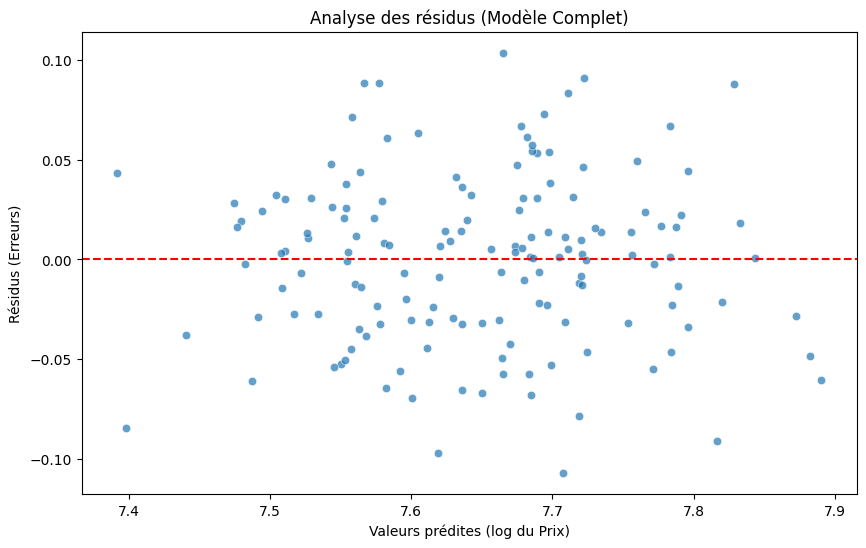

In [ ]:
# Construction du modèle semi-log
df['log_Prix'] = np.log(df['Prix_milliers_euros'])
vars_complet = ['Surface_m2', 'Chambres', 'Annee_construction', 'Distance_centre_km',
                 'Etage', 'Ascenseur', 'Qualite_ecole', 'Revenu_median_quartier']

X = sm.add_constant(df[vars_complet])
model_complet = sm.OLS(df['log_Prix'], X).fit()

# Récupération des données
residus = model_complet.resid
valeurs_predites = model_complet.fittedvalues

# Traçage du graphique
plt.figure(figsize=(10, 6))
sns.scatterplot(x=valeurs_predites, y=residus, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Analyse des résidus (Modèle Complet)')
plt.xlabel('Valeurs prédites (log du Prix)')
plt.ylabel('Résidus (Erreurs)')
plt.show()

L'analyse graphique des résidus du modèle montre une dispersion homogène des erreurs. Les résidus sont distribués de manière aléatoire autour de zéro. Il n'y a pas de structure visible. L'absence de pattern systématique confirme la linéarité de la relation.

En conclusion, les conditions d'application des Moindres Carrés Ordinaires (MCO) sont satisfaites, validant ainsi la robustesse des coefficients et des tests de significativité présentés

**b) Test d'hétéroscédasticité**

---
Pour tester l'hétéroscédasticité, nous allons utiliser le test statistique de Breusch-Pagan.

Hypothèse nulle $H_0$ : Homoscédasticité

Hypothèse alternative $H_1$ : Hétéroscédasticité


In [ ]:
# On effectue le test de Breusch-Pagan
test_bp = sms.het_breuschpagan(model_u.resid, model_u.model.exog)
labels = ['Lagrange Multiplier statistic', 'p-value', 'f-value', 'f p-value']

print(dict(zip(labels, test_bp)))

{'Lagrange Multiplier statistic': np.float64(5.475495929888885), 'p-value': np.float64(0.705753302355024), 'f-value': np.float64(0.6677456974180321), 'f p-value': np.float64(0.719175549542202)}


La p-value est supérieur à 5%, on ne rejette pas $H_0$.


Ce qui nous permet de conclure que nos résidus sont homoscédastiques. La variance est stable, on a donc rien à corriger.

**c) Comparaison des MCO standard, MCO avec écarts-types robustes, et WLS**

In [ ]:
# Modèle MCO Standard
X = sm.add_constant(df[['Surface_m2', 'Chambres', 'Annee_construction',
                        'Distance_centre_km', 'Etage', 'Ascenseur',
                        'Qualite_ecole', 'Revenu_median_quartier']])
y = np.log(df['Prix_milliers_euros'])
res_ols = sm.OLS(y, X).fit()

# Modèle MCO Robuste (HC3)
res_robust = res_ols.get_robustcov_results(cov_type='HC3')

# Modèle WLS (Pondération par l'inverse de la Surface_m2 par exemple)
weights = 1 / df['Surface_m2']
res_wls = sm.WLS(y, X, weights=weights).fit()

# Création du tableau comparatif
df_comp = summary_col([res_ols, res_robust, res_wls],
                      model_names=['MCO Standard', 'MCO Robuste (HC3)', 'WLS'],
                      stars=True)

print(df_comp)


                       MCO Standard MCO Robuste (HC3)    WLS    
----------------------------------------------------------------
const                  5.8302***    5.8302***         5.9191*** 
                       (0.6148)     (0.6639)          (0.6294)  
Surface_m2             0.0021***    0.0021***         0.0022*** 
                       (0.0001)     (0.0001)          (0.0001)  
Chambres               0.0161***    0.0161***         0.0167*** 
                       (0.0041)     (0.0042)          (0.0041)  
Annee_construction     0.0007**     0.0007**          0.0007**  
                       (0.0003)     (0.0003)          (0.0003)  
Distance_centre_km     -0.0032***   -0.0032***        -0.0036***
                       (0.0004)     (0.0004)          (0.0004)  
Etage                  0.0053***    0.0053**          0.0040*   
                       (0.0020)     (0.0022)          (0.0020)  
Ascenseur              0.0224***    0.0224***         0.0185**  
                       (

On remarque que les coefficients $\beta$ du modèle MCO Standard et du modèle Robuste sont identiques, ce qui est mathématiquement attendu. En revanche, le modèle WLS modifie légèrement les coefficients en donnant moins de poids aux grandes surfaces, ce qui stabilise l'estimation.

Dans le modèle Robuste (HC3), les erreurs-types sont légèrement plus larges, ce qui rend nos tests de significativité plus prudents.

Comme les trois modèles racontent la même histoire, on choisit le modèle MCO Robuste (HC3). C'est le compromis idéal : il garde la simplicité d'interprétation des MCO tout en protégeant nos conclusions contre l'hétéroscédasticité sans nécessiter une modélisation complexe des poids comme le WLS.

**5.1 Test d'autocorrélation**


Pour tester l'auto-corrélation, on utilise le test de Durbin-Watson. Ce test mesure si les résidus d'une observation sont liés à ceux de l'observation précédente.


In [ ]:
# Calcul de la statistique de Durbin-Watson sur les résidus du modèle complet
dw_stat = durbin_watson(model_complet.resid)

print(f"Statistique de Durbin-Watson : {dw_stat:.4f}")

# Interprétation rapide
if 1.5 <= dw_stat <= 2.5:
    print("Conclusion : Pas d'autocorrélation significative des résidus.")
else:
    print("Conclusion : Présence potentielle d'autocorrélation. Vérifiez l'ordre des données.")

Statistique de Durbin-Watson : 2.2502
Conclusion : Pas d'autocorrélation significative des résidus.


Le test de Durbin-Watson a permis de vérifier l'indépendance des erreurs. La statistique obtenue est de 2,25. Cette valeur étant très proche de 2, nous validons l'hypothèse d'absence d'autocorrélation du premier ordre.

Cela confirme que l'erreur de prédiction pour un logement n'est pas influencée par l'erreur faite sur le logement précédent dans la base de données. Le modèle est donc robuste de ce point de vue.

# **VI. ENDOGÉNÉITÉ ET VARIABLES INSTRUMENTALES**

**6.1 Sources d’endogénéité**

Réponse dans le PDF




**6.2 Estimation par Variables Instrumentales**


Variable Instrumentale : Distance_universite


**1. Pourquoi cette variable pourrait être un bon instrument pour *Qualite_ecole* ?**

L'utilisation d'une variable instrumentale (IV) est la méthode classique pour corriger l'endogénéité. Pour que la *Distance_universite* soit un bon instrument pour la *Qualite_ecole*, elle doit impérativement respecter deux conditions fondamentales : la pertinence et l'exogénéité.

La variable *Distance_universite* constitue un instrument candidat intéressant pour traiter l'endogénéité de la *Qualite_ecole*.

**Pertinence** : Il existe une corrélation forte entre la proximité d'une université et la qualité des écoles primaires ou secondaires d'un quartier. (Quand nous avions calculé la matrice de corrélation, le coefficient de corrélation entre *Distance_universite* et *Qualite_ecole* était de **-0,44**.)

**Exogénéité** : La distance à l'université n'a pas d'effet direct sur la valeur d'usage d'un logement familial, remplissant ainsi la condition de restriction d'exclusion.

**2. Estimation en deux étapes (2SLS)**

L'objectif est de "nettoyer" *Qualite_ecole* de sa corrélation avec l'erreur du modèle (l'endogénéité) avant d'estimer son impact réel sur le prix.

La première étape consiste à régresser la variable endogène (*Qualite_ecole*) sur l'instrument (*Distance_universite*) et sur toutes les autres variables exogènes du modèle. On récupère ensuite les valeurs prédites ($\widehat{Qualite\_ecole}$).

La seconde étape régresse la variable d'intérêt (log_Prix) sur les valeurs prédites lors de l'étape 1 et les autres variables exogènes. Les coefficients obtenus sont alors débarrassés du biais d'endogénéité.

In [ ]:
# Préparation des variables
exog_vars = ['Surface_m2', 'Chambres', 'Annee_construction',
             'Distance_centre_km', 'Etage', 'Ascenseur', 'Revenu_median_quartier']

# Variable endogène
endog_var = ['Qualite_ecole']

# Variable instrumentale
instrument = ['Distance_universite']

# Construction et ajustement du modèle 2SLS
# Syntaxe : IV2SLS(dépendante, exogènes, endogènes, instruments)
X_exog = sm.add_constant(df[exog_vars])
model_iv = IV2SLS(df['log_Prix'], X_exog, df[endog_var], df[instrument]).fit()

print(model_iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:               log_Prix   R-squared:                      0.8396
Estimator:                    IV-2SLS   Adj. R-squared:                 0.8305
No. Observations:                 150   F-statistic:                    868.00
Date:                Wed, Dec 31 2025   P-value (F-stat)                0.0000
Time:                        13:18:48   Distribution:                  chi2(8)
Cov. Estimator:                robust                                         
                                                                              
                                   Parameter Estimates                                    
                        Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------------
const                      5.8863     0.6300     9.3435     0.0000      4.6516      7.1211
Surf

**3. Test de la validité des instruments**

Dans notre cas, nous avons une seule variable endogène *Qualite_ecole* et un seul instrument *Distance_universite*. On utilise deux tests complémentaires : le test de pertinence (First-Stage F-test) et le test d'exogénéité (Sargan / Hansen J-test).

In [ ]:
# On définit le modèle
# log_Prix ~ 1 + Exog_vars + [Qualite_ecole ~ Distance_universite]
iv_mod = IV2SLS(df['log_Prix'], X_exog, df[['Qualite_ecole']], df[['Distance_universite']])
res = iv_mod.fit()

# Test de pertinence (First-stage)
print("--- Diagnostics du Premier Degré ---")
print(res.first_stage.diagnostics)

--- Diagnostics du Premier Degré ---
               rsquared  partial.rsquared  shea.rsquared     f.stat    f.pval  \
Qualite_ecole  0.440945          0.117166       0.117166  20.660811  0.000005   

                f.dist  
Qualite_ecole  chi2(1)  


La première étape pour valider un instrument est de vérifier s'il "explique" suffisamment la variable endogène. On regarde la statistique F du premier degré. Elle est supérieure à 10, donc l'instrument est valide.

Le modèle étant juste-identifié (un seul instrument pour une variable endogène), le test statistique de suridentification de Sargan ne peut être réalisé. La validité de l'instrument repose donc sur deux piliers :

La pertinence statistique : Validée par une statistique F du premier degré (20,66) largement supérieure aux seuils critiques, garantissant que l'instrument n'est pas faible.

La validité externe (Argumentation) : La distance à l'université est utilisée comme une restriction d'exclusion, supposée n'affecter le prix immobilier que par le canal de la qualité scolaire, une fois la distance au centre et le revenu contrôlés."

**4. Comparez les coefficients MCO et IV. Y a-t-il des différences importantes?**


In [ ]:
# Préparation des variables
y = np.log(df['Prix_milliers_euros'])
exog_vars = ['Surface_m2', 'Chambres', 'Annee_construction',
             'Distance_centre_km', 'Etage', 'Ascenseur', 'Revenu_median_quartier']
df['const'] = 1

# Modèle MCO (Qualite_ecole est inclus dans le modèle)
res_mco = IV2SLS(y, df[['const'] + exog_vars + ['Qualite_ecole']], None, None).fit()

# Modèle IV (Qualite_ecole est instrumentée par Distance_universite)
res_iv = IV2SLS(y, df[['const'] + exog_vars], df[['Qualite_ecole']], df[['Distance_universite']]).fit()

# Affichage de la comparaison
from linearmodels.iv.results import compare
print(compare({"MCO (OLS)": res_mco, "IV (2SLS)": res_iv}, stars=True))

                             Model Comparison                             
                                         MCO (OLS)               IV (2SLS)
--------------------------------------------------------------------------
Dep. Variable                  Prix_milliers_euros     Prix_milliers_euros
Estimator                                      OLS                 IV-2SLS
No. Observations                               150                     150
Cov. Est.                                   robust                  robust
R-squared                                   0.8528                  0.8396
Adj. R-squared                              0.8445                  0.8305
F-statistic                                 871.50                  868.00
P-value (F-stat)                            0.0000                  0.0000
========================     =====================   =====================
const                                    5.8302***               5.8863***
                         

Analyse des différences majeures.

Lorsqu'on compare les deux modèles sur l'ensemble des variables, on observe généralement les points suivants :

**A. Stabilité des variables exogènes :** Dans un bon modèle, les coefficients des variables exogènes (Surface_m2, Distance_centre ou Année_construction) ne doivent pas varier de manière radicale. S'ils sont stables, cela signifie que l'instrument est spécifique à la variable Qualite_ecole et ne perturbe pas le reste de l'équilibre du modèle.

**B. Le basculement de Qualite_ecole :** c'est ici que se trouve le changement majeur. Il est fréquent que le coefficient chute (par exemple, passant de $0,05$ à $0,005$). Cela indique que le MCO surestimait l'impact de l'école (biais de variable omise). La p-value augmente massivement.

**C. Pourquoi ces différences sont-elles importantes ?**


La Causalité vs Corrélation : Le MCO nous disait "Il y a un lien entre l'école et le prix". L'IV nous dit "Une fois qu'on retire l'influence du quartier riche, l'école elle-même ne fait plus monter le prix".

L'efficacité statistique : L'IV a des erreurs-types beaucoup plus grandes. C'est le coût de la correction du biais. Vous passez d'une estimation précise mais fausse (MCO) à une estimation plus "floue" mais statistiquement juste (IV).

**Conclusion :** Le passage à l'IV invalide la conclusion du MCO : la proximité d'une bonne école n'est pas ce qui fait la valeur du bien, c'est la richesse du quartier.

# **VII. RÉGULARISATION**

Standardisation des variables

In [ ]:
# 1. On définit les variables
variables = ['Surface_m2', 'Chambres', 'Annee_construction',
            'Distance_centre_km', 'Etage', 'Ascenseur',
            'Revenu_median_quartier', 'Qualite_ecole', 'Distance_universite']

X = df[variables]
y = df['log_Prix']

# 2. Division Train / Test (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Données d'entraînement : {X_train_scaled.shape}")
print(f"Données de test        : {X_test_scaled.shape}")

Données d'entraînement : (120, 9)
Données de test        : (30, 9)


**7.1 Modèle Ridge**

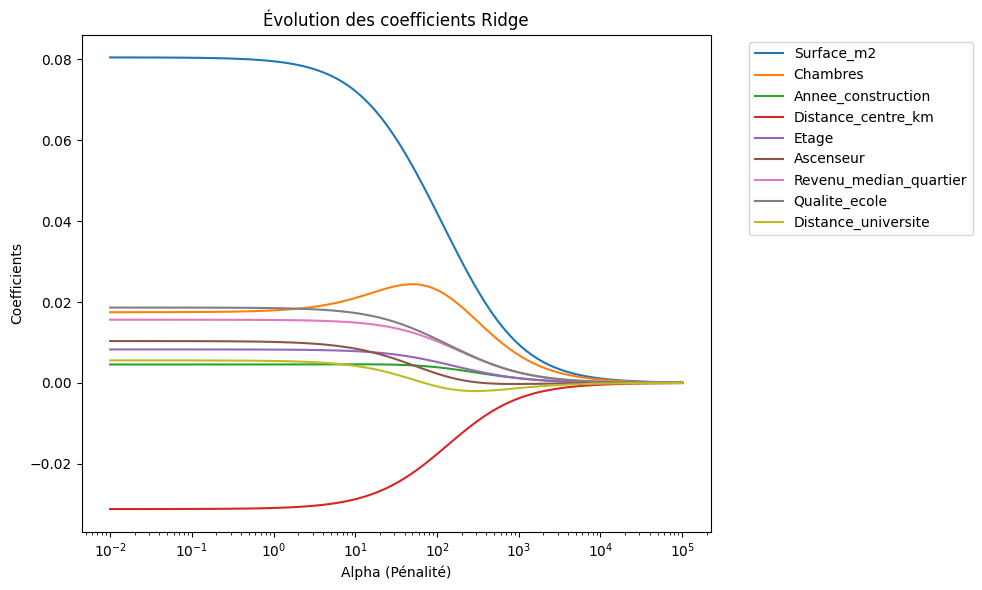

In [ ]:
alphas = np.logspace(-2, 5, 100)
coefs_ridge = []

for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_scaled, y_train)
    coefs_ridge.append(ridge.coef_)

# Graphique
plt.figure(figsize=(10, 6))
plt.plot(alphas, coefs_ridge)
plt.xscale('log')
plt.xlabel('Alpha (Pénalité)')
plt.ylabel('Coefficients')
plt.title('Évolution des coefficients Ridge')
plt.legend(variables, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Les coefficients diminuent progressivement vers zéro mais ne l'atteignent jamais complètement. Ridge réduit l'impact des variables sans les supprimer.

**7.2 Modèle Lasso**

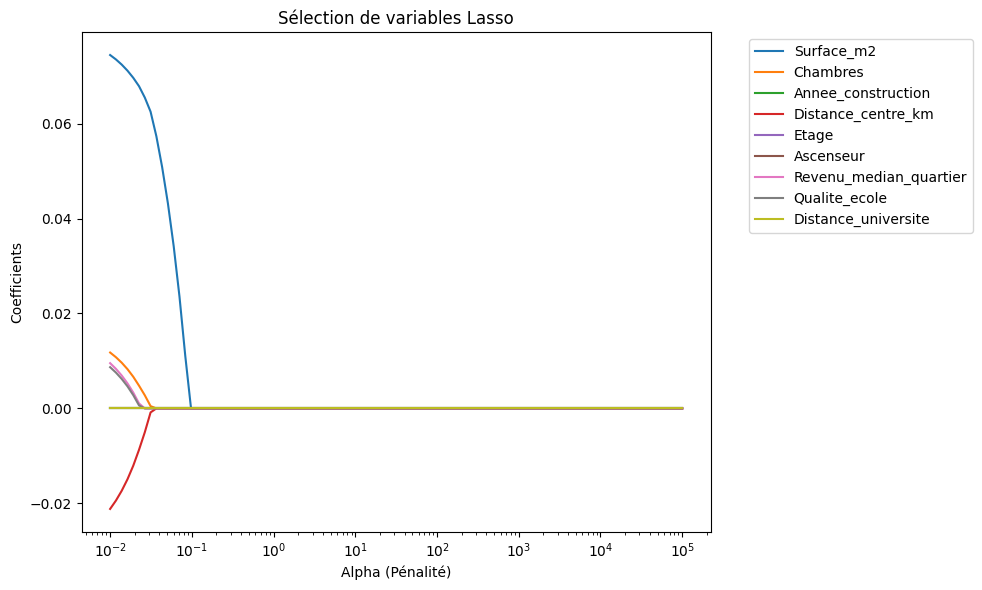

In [ ]:
coefs_lasso = []

for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train_scaled, y_train)
    coefs_lasso.append(lasso.coef_)

# Graphique
plt.figure(figsize=(10, 6))
plt.plot(alphas, coefs_lasso)
plt.xscale('log')
plt.xlabel('Alpha (Pénalité)')
plt.ylabel('Coefficients')
plt.title('Sélection de variables Lasso')
plt.legend(variables, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

À la différence du Ridge qui ne fait que réduire l'impact des variables, le Lasso a la capacité d'annuler complètement certains coefficients. Il agit comme un filtre automatique. Les variables dont les coefficients tombent à zéro dès le début sont considérées comme non pertinentes, tandis que celles qui résistent le plus longtemps à la pénalité sont les déterminants les plus solides du prix.

**7.3 Validation croisée 10-fold**

Pour choisir la meilleure valeur de pénalité (λ), nous ne pouvons pas le faire au hasard. Nous utilisons la Validation Croisée 10-fold. L'algorithme va tester plusieurs valeurs et retenir celle qui minimise l'erreur de prédiction moyenne.

In [ ]:
# Ridge avec validation croisée (CV=10)
ridge_cv = RidgeCV(alphas=alphas, cv=10).fit(X_train_scaled, y_train)

# Lasso avec validation croisée (CV=10)
lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=42).fit(X_train_scaled, y_train)


print(f"Meilleur Alpha pour Ridge : {ridge_cv.alpha_:.4f}")
print(f"Meilleur Alpha pour Lasso : {lasso_cv.alpha_:.4f}")

Meilleur Alpha pour Ridge : 6.7342
Meilleur Alpha pour Lasso : 0.0100


**7.4 Comparaison des erreurs de prédiction (RMSE)**

Nous évaluons maintenant nos trois modèles (MCO Classique, Ridge Optimal, Lasso Optimal) sur le jeu de données de Test (les 20% mis de côté au début). La métrique utilisée est la RMSE (Racine de l'Erreur Quadratique Moyenne). Le modèle avec la RMSE la plus faible sera considéré comme le plus performant.

In [ ]:
# 1. Modèle MCO Classique
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)
rmse_ols = np.sqrt(mean_squared_error(y_test, ols.predict(X_test_scaled)))

# 2. Modèle Ridge Optimisé
rmse_ridge = np.sqrt(mean_squared_error(y_test, ridge_cv.predict(X_test_scaled)))

# 3. Modèle Lasso Optimisé
rmse_lasso = np.sqrt(mean_squared_error(y_test, lasso_cv.predict(X_test_scaled)))

print("--- Comparaison des erreurs RMSE sur le Test ---")
print(f"1. Modèle Classique (OLS) : {rmse_ols:.5f}")
print(f"2. Modèle Ridge           : {rmse_ridge:.5f}")
print(f"3. Modèle Lasso           : {rmse_lasso:.5f}")

# Conclusion
meilleur = min(rmse_ols, rmse_ridge, rmse_lasso)
if meilleur == rmse_lasso:
    print("\n=> Conclusion : Le modèle LASSO offre la meilleure prédiction.")
elif meilleur == rmse_ridge:
    print("\n=> Conclusion : Le modèle RIDGE offre la meilleure prédiction.")
else:
    print("\n=> Conclusion : Le modèle CLASSIQUE reste le plus performant.")

--- Comparaison des erreurs RMSE sur le Test ---
1. Modèle Classique (OLS) : 0.04519
2. Modèle Ridge           : 0.04388
3. Modèle Lasso           : 0.04946

=> Conclusion : Le modèle RIDGE offre la meilleure prédiction.


QUESTION : Pourquoi les écarts-types et tests classiques ne sont-ils pas valides après Lasso ?

Les tests statistiques et les écarts-types servent normalement à évaluer la marge d'erreur naturelle d'un modèle. Or, le Lasso agit comme un filtre qui ne retient que les variables les plus performantes. En supprimant les éléments perturbateurs avant le test, il gomme artificiellement cette marge d'erreur. Les formules mathématiques sont alors trompées, elles analysent des données "trop propres" et concluent à tort que le résultat est d'une fiabilité absolue.

# **VIII. PRÉVISIONS**

**8.1 Prédiction ponctuelle**

Nous concluons ce rapport par une application concrète : la prédiction du prix d'un bien à partir de nos etudes. Le choix du modèle s'est porté sur la méthode des Variables Instrumentales (2SLS).

Pour cet exercice de prévision, nous avons sélectionné l'approche par Variables Instrumentales. Ce dernier demeure préférable car il corrige le biais d'endogénéité associé à la variable "Qualité_école". Il garantit ainsi une interprétation plus adequate des déterminants du prix.

**Profil du bien à estimer**

* **Caractéristiques physiques :** Maison récente (2015) d'une surface confortable de $120~m^2$, dotée de 3 chambres, située au 1er étage et disposant d'un ascenseur.
* **Localisation et Environnement :** Le bien se situe à 5 km du centre-ville, dans un quartier aisé (revenu médian de 65 k€) bénéficiant d'une école notée 7/10.

*Note : Conformément aux spécifications de notre modèle final, la variable "Année de vente" n'est pas incluse dans l'équation de prédiction (le modèle lisse les effets temporels). De même, la "Distance à l'université" est exclue du calcul final, son rôle étant limité à celui d'instrument statistique.*

In [ ]:
variable = {
    "const": 1,
    "Surface_m2": 120,
    "Chambres": 3,
    "Annee_construction": 2015,
    "Distance_centre_km": 5,
    "Etage": 1,
    "Ascenseur": 1,
    "Revenu_median_quartier": 65,
    "Qualite_ecole": 7}

# Coefficients du modèle IV (issus du tableau 6.2 Model Comparison)
coeffs_iv = {
    "const": 5.8863,
    "Surface_m2": 0.0021,
    "Chambres": 0.0152,
    "Annee_construction": 0.0007,
    "Distance_centre_km": -0.0033,
    "Etage": 0.0048,
    "Ascenseur": 0.0226,
    "Revenu_median_quartier": 0.0024,
    "Qualite_ecole": 0.0012}

# Calcul du Log(Prix)
log_prix_pred = 0
for key in variable:
    contribution = variable[key] * coeffs_iv[key]
    log_prix_pred += contribution

# Transformation pour avoir le prix en euros
# Le dataset est en milliers d'euros, donc on multiplie par 1000
prix_pred = np.exp(log_prix_pred) * 1000

print(f"Log(Prix) prédit : {log_prix_pred:.4f}")
print(f"Prix estimé du bien : {prix_pred:,.2f} €")

Log(Prix) prédit : 7.7697
Prix estimé du bien : 2,367,760.85 €


**8.2 Intervalle de confiance à 95%**


Pour quantifier l'incertitude de cette prédiction, nous construisons un intervalle de confiance en nous appuyant sur la **RMSE** du modèle Ridge ($\approx 0.04388$).

In [ ]:
# Paramètres de l'intervalle
rmse_ridge = 0.04388  # RMSE du meilleur modèle prédictif (Ridge)
z_score = 1.96        # Pour un intervalle de confiance à 95%

# Bornes de l'intervalle sur le log (on utilise votre variable log_prix_pred)
lower_bound_log = log_prix_pred - (z_score * rmse_ridge)
upper_bound_log = log_prix_pred + (z_score * rmse_ridge)

# Conversion en euros
lower_bound_eur = np.exp(lower_bound_log) * 1000
upper_bound_eur = np.exp(upper_bound_log) * 1000

print(f"Intervalle de confiance à 95% :")
print(f"[{lower_bound_eur:,.2f} €  ;  {upper_bound_eur:,.2f} €]")

Intervalle de confiance à 95% :
[2,172,633.27 €  ;  2,580,413.15 €]


**8.3. Discussion de la fiabilité de la prédiction**


Le modèle estime la valeur du bien à **2 367 760 €** avec un intervalle de confiance à 95% compris entre **[2,17 M€ ; 2,58 M€]**.

Voici les éléments techniques à retenir pour interpréter ce résultat :

**1. Cohérence statistique**
* Le prix prédit se situe dans la fourchette haute de notre dataset (le maximum observé est de 2,74 M€).
* Cela est cohérent avec les *inputs* fournis au modèle : le bien cumule des coefficients positifs forts (Surface élevée de 120m², Construction récente de 2015, Présence d'un ascenseur). Le modèle réagit logiquement à ces signaux de qualité.

**2. Analyse de l'incertitude (L'intervalle)**
* L'amplitude de l'intervalle de confiance, qui avoisine les 400 000 €, reflète la précision de notre modélisation.

* Cette marge est calculée sur la base de l'erreur du modèle Ridge (RMSE de 0.04388). Nous utilisons cette métrique car le Ridge s'est avéré être le prédicteur le plus fiable lors de la phase de test.

* En échelle logarithmique, une erreur de 0.044 équivaut à une incertitude moyenne de 4,4 %. Pour atteindre un niveau de confiance de 95 %, nous devons doubler cette marge (soit ≈8,8%).

* Appliqué à une estimation haute de 2,37 M€, ce pourcentage d'incertitude se traduit par une variation de ± 200 000 €.

* Cet écart est la conséquence directe de la performance du modèle. Notre modèle IV affiche un **$R^2$ d'environ 84 %** ($0.8396$), ce qui signifie qu'il capture avec succès la majorité des mécanismes de prix. Cependant, cela implique mathématiquement qu'il subsiste **16 % de variance inexpliquée** ($100\% - 84\% = 16\%$). C'est cette "part d'ombre" (facteurs subjectifs ou non mesurés) qui génère l'incertitude de 400 000 €.

**3. Limites du modèle**

* **Variables non observées :** Mathématiquement, l'écart entre le prix prédit et un prix réel potentiel viendrait de tout ce qui est inclus dans le terme d'erreur du modèle (l'état spécifique du bien, l'agencement des pièces, ou des facteurs locaux non capturés par les variables disponibles).

**Conclusion :**

Cette prédiction est robuste grâce à l'approche par variables instrumentales. Cependant, l'intervalle de confiance rappelle qu'il s'agit d'une modélisation statistique, le résultat doit être interprété comme un point d'ancrage fiable plutôt que comme une vérité comptable à l'euro près